In [20]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from nilearn import image
from tqdm import tqdm
from os.path import join as opj
from scipy.spatial.distance import squareform
from matplotlib.colors import ListedColormap

In [34]:
final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
# Atlas
atlas_img = image.load_img("../data/atlases/shen_2mm_268_parcellation.nii.gz")
shen_rsns = pd.read_csv("../data/atlases/shen_268_parcellation_networklabels.csv")
shen_rsns.head()

rsn_lables = ['medial-frontal', 'frontoparietal', 'default-mode','subcortical-cerebellum',
              'motor', 'visual-1', 'visual-2', 'visual-association']
print(rsn_lables)
# Add colours to each network (R, G, B)
rsn_colors = [[128,0,128], [0,255,255], [255,215,0], [255,69,0],
              [0,0,128], [255,0,255], [0,255,0], [128,0,0]
             ]
print(rsn_colors)

rsn_norm_colors = [(rgb[0]/255, rgb[1]/255, rgb[2]/255) for rgb in rsn_colors]
rsn_cmap = ListedColormap(rsn_norm_colors)
print(rsn_cmap)

netassignments = shen_rsns.Network.to_numpy()
print(netassignments)

# Increasing order to rearrange matrices
indsort = shen_rsns.sort_values("Network").index.to_numpy()
print(indsort)

['medial-frontal', 'frontoparietal', 'default-mode', 'subcortical-cerebellum', 'motor', 'visual-1', 'visual-2', 'visual-association']
[[128, 0, 128], [0, 255, 255], [255, 215, 0], [255, 69, 0], [0, 0, 128], [255, 0, 255], [0, 255, 0], [128, 0, 0]]
[2 4 3 2 3 3 2 2 2 1 4 1 3 2 4 1 2 4 2 4 2 2 5 5 5 5 5 4 4 2 2 4 5 5 5 4 5
 5 5 5 8 6 8 4 5 5 2 2 3 3 5 1 1 1 2 1 1 5 8 5 5 5 5 1 1 8 8 6 8 2 8 6 8 8
 6 7 6 7 6 6 7 6 4 5 3 3 6 4 5 3 4 5 4 4 4 3 5 6 4 7 4 7 4 4 4 4 4 4 5 4 2
 2 4 4 3 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 1 3 2 1 3 2 2 4 1 4 2 1
 1 1 1 4 1 2 4 1 2 5 5 5 5 1 5 2 1 5 5 5 4 5 5 5 5 5 8 6 8 4 5 5 5 2 1 2 1
 1 1 5 5 1 5 1 2 1 5 2 5 6 2 8 8 5 3 8 6 8 6 6 8 8 6 7 7 7 6 6 4 5 1 4 4 3
 3 4 3 4 3 5 4 4 4 4 4 4 5 4 4 4 3 8 7 2 4 4 4 2 2 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4]
[164  52  51 147 193 148 191 161 189 185 184 149 182 150 152 186 218  53
 155  56  15 144  11 139   9  55  63  64 136 153 110 111  69 115  54 138
 141 146 142  46  47   0 163 246 245   3 241   6   7   8 156 

In [3]:
def load_edge_results(task_id, contrast, method="fdr_bh", alpha = 0.05):
    from scipy.stats import norm
    from scipy.spatial.distance import squareform
    from statsmodels.stats.multitest import multipletests
    base_dir = opj("../results/second-level/edge/shen/task-%s" % task_id, contrast)
    
    res_second = dict()
    for name in ["stat", "z_score"]:
        res_second[name] = np.squeeze(image.load_img(opj(base_dir, "%s.nii.gz" % name)).get_fdata())
    
    p_values = norm.sf(abs(squareform(res_second['z_score'], checks=False)))*2 #two-sided
    res_second['p_values'] = squareform(p_values)
    is_sig,_,_,_ = multipletests(p_values, method = method, alpha = alpha)

    res_second['is_significant'] = squareform(is_sig)
    res_second['stat_corrected'] = squareform(is_sig)*res_second["stat"]
    
    return res_second

In [13]:
stroop_second = load_edge_results(task_id = "stroop", contrast = "Incongruent-Congruent", method="holm")
msit_second = load_edge_results(task_id = "msit", contrast = "Incongruent-Congruent", method="holm")

In [122]:
mak

NameError: name 'divider' is not defined

In [129]:
def stat_mat_figure(stat_mat):
    
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
    from nilearn.plotting import cm as ni_cm
    from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

    n = stat_mat.shape[0]
    
    stat_mat = squareform(squareform(stat_mat, checks=False))
    stat_mat_sorted = stat_mat[indsort,:][:, indsort.T]
    
    vmin = np.min(stat_mat_sorted)
    vmax = np.max(stat_mat_sorted)
    
    norm = mpl.colors.TwoSlopeNorm(vmin= vmin,  vcenter=0, vmax = vmax)

    fig, ax = plt.subplots(figsize=(10,10))
    divider = make_axes_locatable(ax)
    yhax = divider.append_axes("right", size=0.5, pad = 0.01)
    xhax = divider.append_axes("top", size=0.5, pad = 0)

    im = ax.imshow(stat_mat_sorted, aspect='equal', cmap=nilearn_cmaps['cold_white_hot'], norm=norm)

    yhax.imshow(netassignments[indsort].astype(int).reshape(-1, 1), aspect=0.05,
                cmap=rsn_cmap)
    yhax.set_xticks([])
    yhax.set_yticks([])
    xhax.imshow(netassignments[indsort].astype(int).reshape(1, -1), aspect=1/0.05,
                cmap=rsn_cmap)
    xhax.set_xticks([])
    xhax.set_yticks([])

    unique_rsn, vcount = np.unique(netassignments, return_counts=True)

    y_o = 0

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("Regions", fontsize = 25)
    ax.tick_params(axis="both", labelsize=15)
    yhax.set_axis_off()
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=.04, pad=0.1)
    cbar.ax.set_xlabel('Stats', fontsize=20, fontweight='bold', labelpad=10)
    cbar.ax.tick_params(labelsize=12)
    return fig


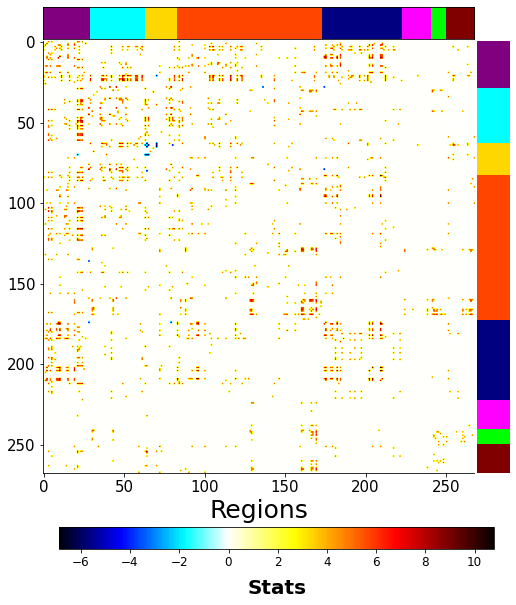

In [131]:
fig = stat_mat_figure(stroop_second['stat_corrected'])
plt.savefig("../plots/second-level/edge/shen/task-stroop/stats_mat_holm05.png", dpi=300)
plt.savefig("../plots/second-level/edge/shen/task-stroop/stats_mat_holm05.svg", dpi=300)
plt.savefig("../plots/second-level/edge/shen/task-stroop/stats_mat_holm05.pdf", dpi=300)

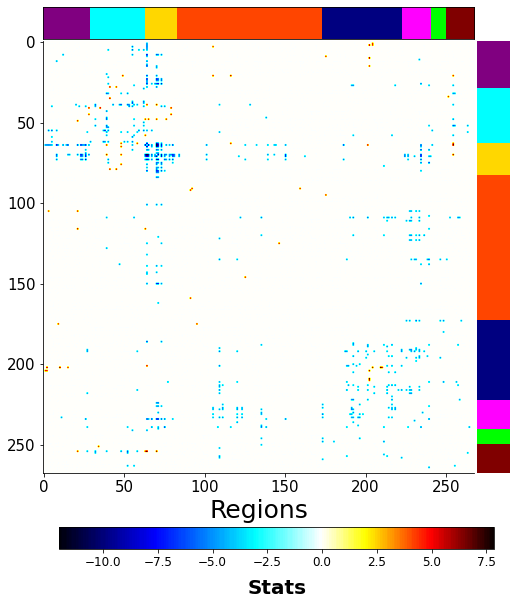

In [132]:
fig = stat_mat_figure(msit_second['stat_corrected'])
plt.savefig("../plots/second-level/edge/shen/task-msit/stats_mat_holm05.png", dpi=300)
plt.savefig("../plots/second-level/edge/shen/task-msit/stats_mat_holm05.svg", dpi=300)
plt.savefig("../plots/second-level/edge/shen/task-msit/stats_mat_holm05.pdf", dpi=300)